# Experiments with K-Means Clustering and PCA 
 - Dataset: [SVNH Dataset](http://ufldl.stanford.edu/housenumbers/) (Format 2)

#### a) Perform k means clustering with k=10 on the raw data and on data obtained after PCA dimensionality reduction for dimension as found in question 1 (a) and for dimension 10 as in question 1 (b). You may use only training data of SVHN to perform this. Do you observe images from the same class to be clustered together ? For each cluster, provide the image closest to the centroid.


In [1]:
from sklearn.cluster import KMeans
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed
np.random.seed(42)

### Data Preparation

In [2]:
train_data = './data/train_32x32.mat'
test_data = './data/test_32x32.mat'

train = sio.loadmat(train_data)
test = sio.loadmat(test_data)

X_train, y_train = train['X'], train['y']
X_test, y_test = test['X'], test['y']

print(f'Before reshaping: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Before reshaping: X_test: {X_test.shape}, y_test: {y_test.shape}')

# Reshape the data to NxHxWxC
X_train = X_train.transpose((3, 0, 1, 2))
X_test = X_test.transpose((3, 0, 1, 2))
# Make y_test and y_train into a 1D array
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Change all the 10s in the labels to 0s
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

print(f'After reshaping: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'After reshaping: X_test: {X_test.shape}, y_test: {y_test.shape}')

Before reshaping: X_train: (32, 32, 3, 73257), y_train: (73257, 1)
Before reshaping: X_test: (32, 32, 3, 26032), y_test: (26032, 1)
After reshaping: X_train: (73257, 32, 32, 3), y_train: (73257,)
After reshaping: X_test: (26032, 32, 32, 3), y_test: (26032,)


Image shape: (32, 32, 3), Label: 9


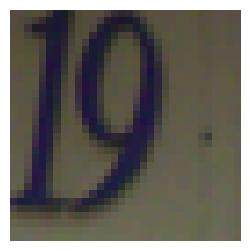

In [3]:
idx = 1
image, label = X_train[idx], y_train[idx]
print(f'Image shape: {image.shape}, Label: {label}')

# Visualise image with matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
# Pick 2500 samples from each class
print(f'min: {np.min(y_train)}, max: {np.max(y_train)}')
X_samples, y_samples = [], []
for i in range(10):
    indices = np.where(y_train == i)[0]
    random_indices = np.random.choice(indices, 2500, replace=False)
    X_samples.append(X_train[random_indices])
    y_samples.append(y_train[random_indices])

X_train, y_train = np.concatenate(X_samples), np.concatenate(y_samples)
print(f'After sampling: train_X: {X_train.shape}, train_y: {y_train.shape}')

min: 0, max: 9
After sampling: train_X: (25000, 32, 32, 3), train_y: (25000,)


In [5]:
def find_centroids(
    X:np.ndarray,
    n_clusters:int=10,
    scale:bool=False,
    verbose:bool=False
    ):
    """ Finds the centroids using KMeans clustering
        params:
            X: The data to cluster (NxD)
            n_clusters: The number of clusters to use
            scale: Whether to scale the data or not
            verbose: Set to true to print iterations
        returns:
            The centroids of the clusters, labels, indices closest to each centroid, sum squared error
    """

    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, max_iter=100, random_state=42, verbose=verbose)
    scaler = StandardScaler()

    if scale:
        X = scaler.fit_transform(X)
    kmeans.fit(X)
    
    # Find point closest to each centroid
    closest_points = np.zeros(n_clusters)
    for i in range(n_clusters):
        closest_points[i] = np.argmin(np.sum((X - kmeans.cluster_centers_[i])**2, axis=1))

    sum_squared_error = kmeans.inertia_

    centroids = scaler.inverse_transform(kmeans.cluster_centers_) if scale else kmeans.cluster_centers_
    cluster_assignment = kmeans.labels_
    
    return centroids, cluster_assignment, closest_points, sum_squared_error
    

def min_max_normalise(X):
    """Normalize X to constrain all values between 0 and 1"""
    return (X - np.min(X)) / (np.max(X) - np.min(X))

In [6]:
# Find centroids with normal data
print(X_train.shape)
centroids, labels, closest_idxs, sse = find_centroids(X_train.reshape(25000, -1), scale=True)

(25000, 32, 32, 3)


Text(0.5, 0.98, 'Closest images to centroids')

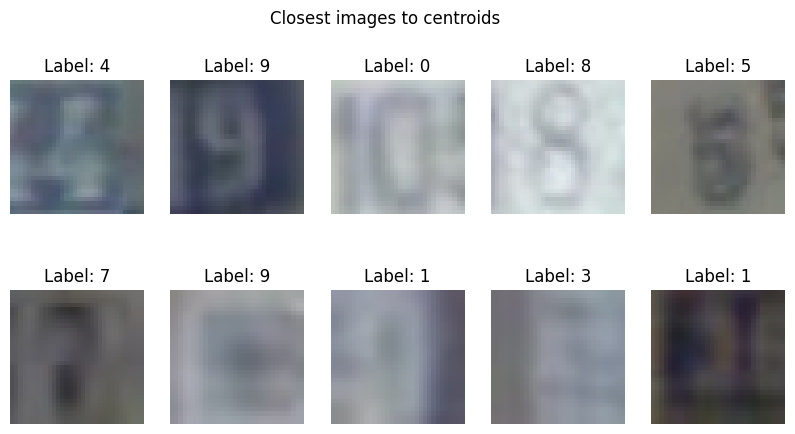

In [7]:
# Visualise point closest to each centroid
closest_idxs = closest_idxs.astype(int)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[closest_idxs[i]])
    ax.axis('off')
    ax.set_title(f'Label: {y_train[closest_idxs[i]]}')
plt.suptitle('Closest images to centroids')

In [8]:
# Print the labels in each cluster
for i in range(10):
    print(f'Cluster {i}: | {np.bincount(y_train[labels == i])}')

Cluster 0: | [247 234 226 228 275 237 249 225 297 218]
Cluster 1: | [313 297 312 322 298 338 312 333 311 369]
Cluster 2: | [250 217 250 230 234 237 228 234 202 212]
Cluster 3: | [128 136 135 132 115 107 131 104 121 112]
Cluster 4: | [381 352 374 381 365 389 379 419 377 402]
Cluster 5: | [374 382 378 383 400 392 379 342 401 368]
Cluster 6: | [348 306 291 281 324 309 305 302 306 322]
Cluster 7: | [178  88  94 106 116 104 151 134 154 124]
Cluster 8: | [ 22 186 159 127 107  95  74 100  75  83]
Cluster 9: | [259 302 281 310 266 292 292 307 256 290]


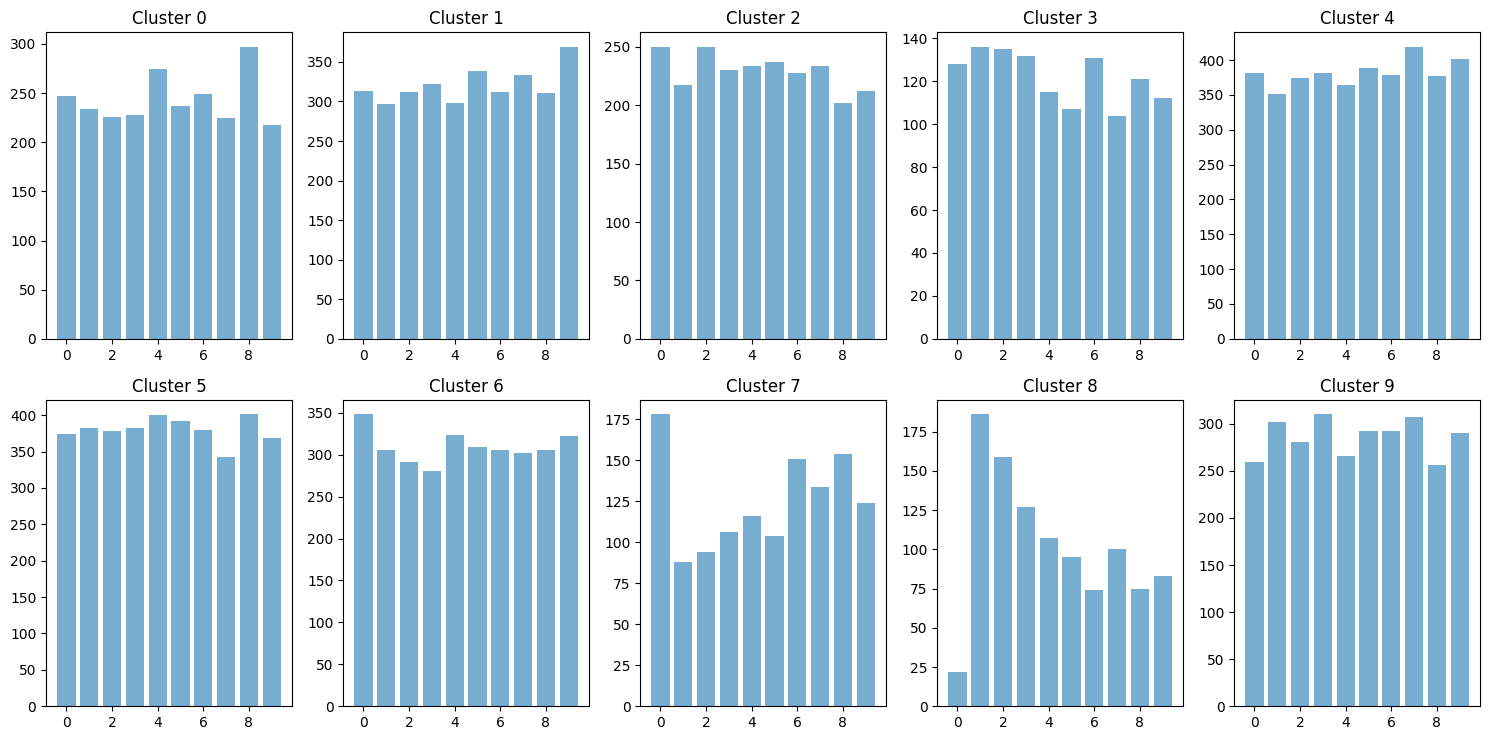

In [9]:
# Plot distribution of labels
fig, axes = plt.subplots(2, 5, figsize=(15, 7.5))

for i, ax in enumerate(axes.flat):
    ax.bar(np.arange(10), np.bincount(y_train[labels == i]), alpha=0.6)
    ax.set_title(f'Cluster {i}')
    ax.set_xticks(np.arange(0, 10, 2))

plt.tight_layout()

In [10]:
# Find centroids with PCA with 26 components
pca_26 = PCA(n_components=26)
pca_26.fit(X_train.reshape(-1, 32 * 32 * 3))
X_train_pca_26 = pca_26.transform(X_train.reshape(-1, 32 * 32 * 3))

centroids_pca_26, labels_pca_26, closest_idxs_pca_26, sse_26 = find_centroids(X_train_pca_26, scale=True)

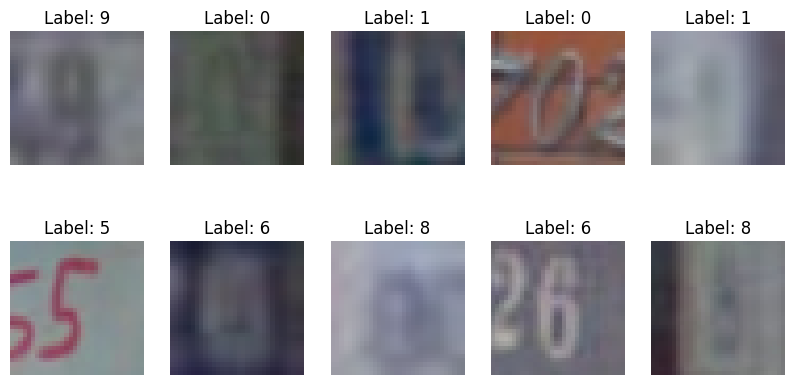

In [11]:
# visualise point closest to each pca centroid
closest_idxs_pca_26 = closest_idxs_pca_26.astype(int)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[closest_idxs_pca_26[i]])
    ax.axis('off')
    ax.set_title(f'Label: {y_train[closest_idxs_pca_26[i]]}')

In [12]:
# Print the labels in each cluster
for i in range(10):
    print(f'Cluster {i}: | {np.bincount(y_train[labels_pca_26 == i])}')

Cluster 0: | [347 130 161 176 173 218 237 251 217 266]
Cluster 1: | [558 503 617 567 450 551 541 572 561 562]
Cluster 2: | [ 71 614 144 108 689 109 138 195 111 127]
Cluster 3: | [79 77 81 69 77 84 92 74 87 95]
Cluster 4: | [294 107 146 164 154 177 224 232 243 218]
Cluster 5: | [265 227 284 304 152 395 289 381 367 377]
Cluster 6: | [270  58 267 368  36 337 311 281 293 276]
Cluster 7: | [230 412 420 374 558 300 317 273 248 197]
Cluster 8: | [348  61 118 122  25 171 221  78 280 246]
Cluster 9: | [ 38 311 262 248 186 158 130 163  93 136]


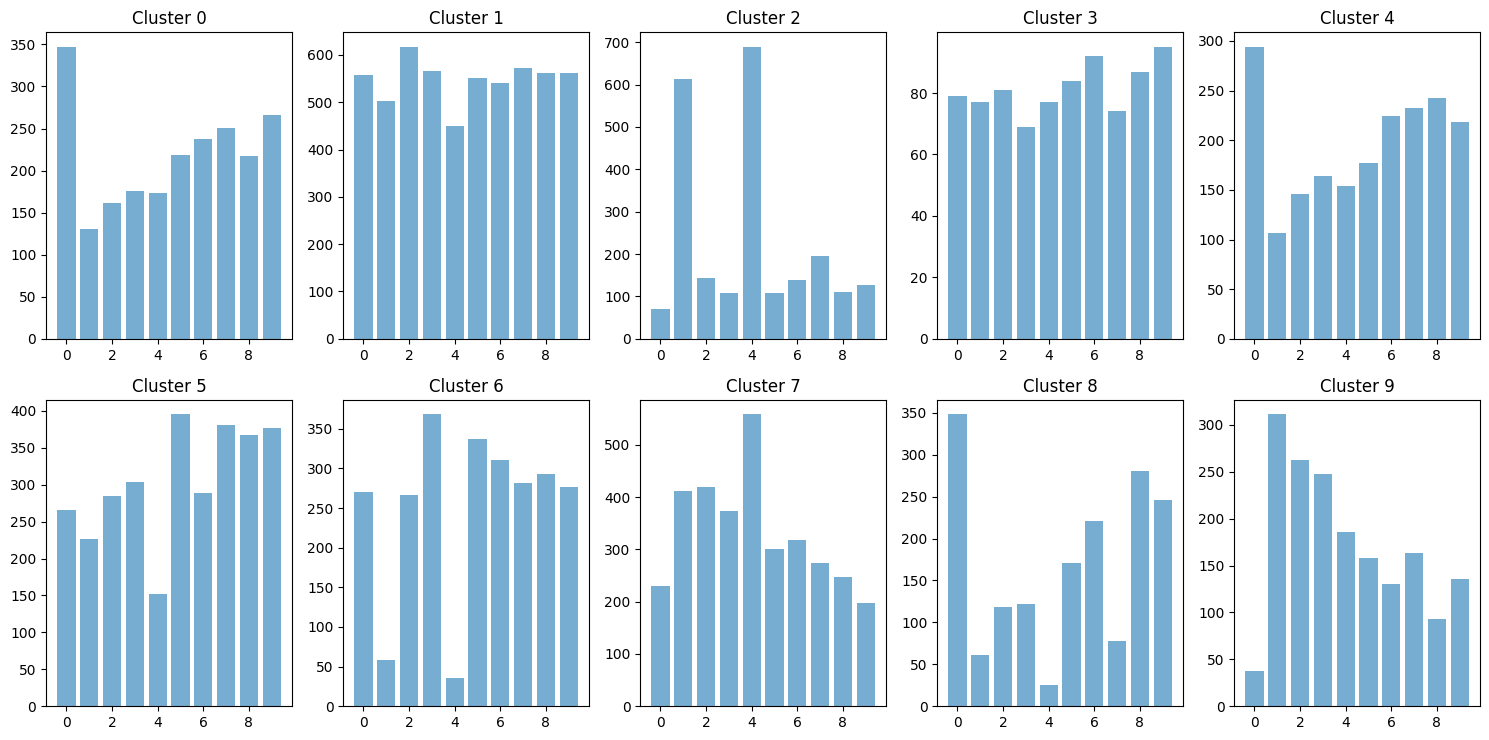

In [13]:
# Plot distribution of labels
fig, axes = plt.subplots(2, 5, figsize=(15, 7.5))

for i, ax in enumerate(axes.flat):
    ax.bar(np.arange(10), np.bincount(y_train[labels_pca_26 == i]), alpha=0.6)
    ax.set_title(f'Cluster {i}')
    ax.set_xticks(np.arange(0, 10, 2))

plt.tight_layout()

In [14]:
# Find centroids with PCA with 10 components
pca_10 = PCA(n_components=10)
pca_10.fit(X_train.reshape(-1, 32 * 32 * 3))
X_train_pca_10 = pca_10.transform(X_train.reshape(-1, 32 * 32 * 3))

centroids_pca_10, labels_pca_10, closest_idxs_pca_10, sse_10 = find_centroids(X_train_pca_10, scale=True)

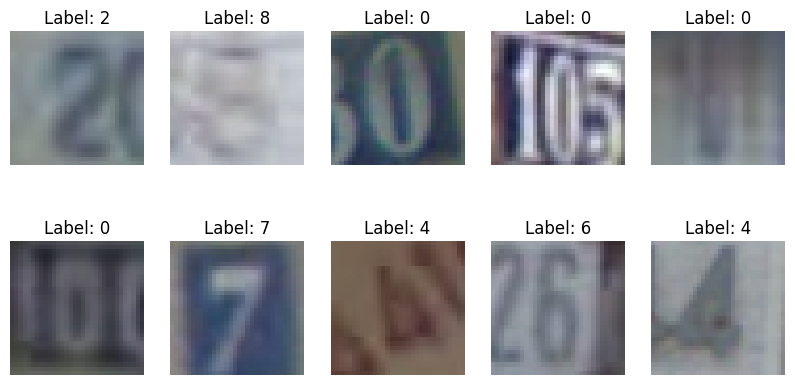

In [15]:
# visualise point closest to each pca centroid
closest_idxs_pca_10 = closest_idxs_pca_10.astype(int)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[closest_idxs_pca_10[i]])
    ax.axis('off')
    ax.set_title(f'Label: {y_train[closest_idxs_pca_10[i]]}')

In [16]:
# Print the labels in each cluster
for i in range(10):
    print(f'Cluster {i}: | {np.bincount(y_train[labels_pca_10 == i])}')

Cluster 0: | [174 376 426 466 437 351 228 299 269 354]
Cluster 1: | [277 209 235 221 178 227 217 175 224 216]
Cluster 2: | [387  78  67 153  75 241 385  14 329 292]
Cluster 3: | [ 27 271 255 226 175 160 117 143  94 123]
Cluster 4: | [139  91 117 127 110 120 101 254 129 164]
Cluster 5: | [485 414 529 493 428 516 451 432 494 501]
Cluster 6: | [158 446 292 229 297 171 134 502 122 128]
Cluster 7: | [261 251 250 239 247 257 248 231 263 229]
Cluster 8: | [292 107 155 169 170 201 244 221 229 223]
Cluster 9: | [300 257 174 177 383 256 375 229 347 270]


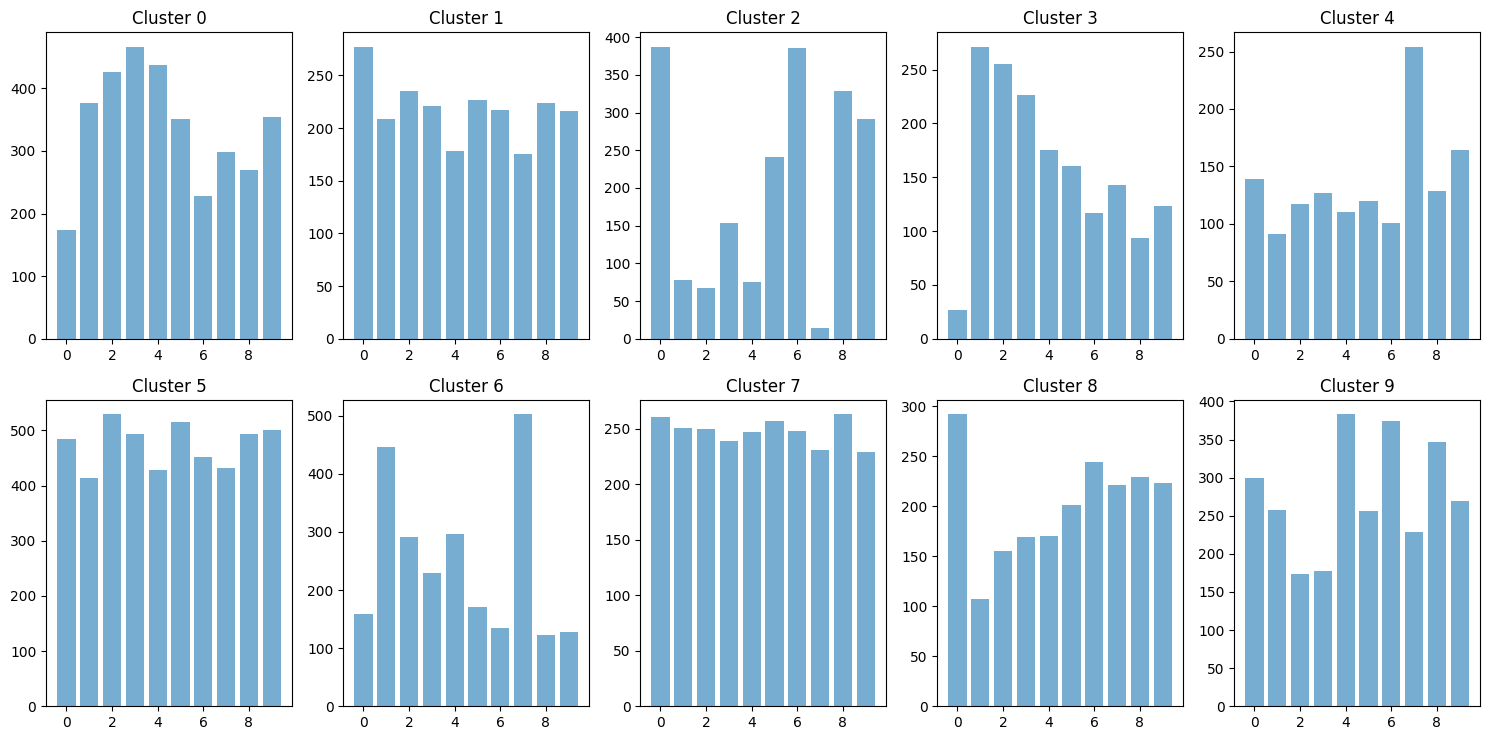

In [17]:
# Plot distribution of labels
fig, axes = plt.subplots(2, 5, figsize=(15, 7.5))

for i, ax in enumerate(axes.flat):
    ax.bar(np.arange(10), np.bincount(y_train[labels_pca_10 == i]), alpha=0.6)
    ax.set_xticks(np.arange(0, 10, 2))
    ax.set_title(f'Cluster {i}')

plt.tight_layout()

From the bar-graphs, we can make the following observations:
- Clustering without dimensionality reduction seems to yield mostly random clusters. The distribution of classes is uniform in each cluster.
- Clustering with PCA ($26$ dimensions) seems to yield more explainable results. For example:  The labels $1$ and $4$, and the digits $0$ and $8$ occur together more frequently due to the presence of a similarities in their structure.
- Reducing the dimensionality to $10$ results in some data loss, and the patterns are less meaningful. However, we can still explain some observations: for instance the digits $1$ and $7$ occur together. 

#### (b) Find the sum squared error for each of these different clustering obtained in 2(a). Make use of the label information associated with the images to evaluate your clustering. Specifically, evaluate the goodness of your clusters for various cases in 2(a) by using two evaluation metrics purity and rand-index.

In [34]:
# Print the sum squared error for each method
print(f'SSE for normal data: {sse}')
print(f'SSE for PCA with 26 components: {sse_26}')
print(f'SSE for PCA with 10 components: {sse_10}')

SSE for normal data: 31422759.65484619
SSE for PCA with 26 components: 565376.2317135681
SSE for PCA with 10 components: 172516.2322297992


In [35]:
# Purity: Number of correctly matched classes / Total number of samples
def purity(
    labels:np.ndarray,
    y:np.ndarray,
    n_classes:int=10
    ):
    """ Calculates the purity of the clusters
        params:
            labels: The labels assigned to each cluster
            y: The true labels of the data
        returns:
            The purity of the clusters
    """

    correct_preds = 0

    for i in range(n_classes):
        cluster_label = np.argmax(np.bincount(y[labels == i]))
        correct_preds += np.sum(y[labels == i] == cluster_label)

    return correct_preds / y.shape[0]

In [36]:
# Print purity for each method
print(f'Purity for normal data: {purity(labels, y_train)}')
print(f'Purity for PCA with 26 components: {purity(labels_pca_26, y_train)}')
print(f'Purity for PCA with 10 components: {purity(labels_pca_10, y_train)}')

Purity for normal data: 0.11576
Purity for PCA with 26 components: 0.16088
Purity for PCA with 10 components: 0.14496


In [37]:
# Print rand index for each method

from sklearn.metrics import rand_score

print(f'Rand index for normal data: {rand_score(labels, y_train)}')
print(f'Rand index for PCA with 26 components: {rand_score(labels_pca_26, y_train)}')
print(f'Rand index for PCA with 10 components: {rand_score(labels_pca_10, y_train)}')

Rand index for normal data: 0.8075937085483419
Rand index for PCA with 26 components: 0.8046172630905236
Rand index for PCA with 10 components: 0.8109006632265291


#### (c) If you label each cluster with the digit that occurs most frequently within it, then what is your classification accuracy with this unsupervised method for various cases ? How does this compare with the accuracy you got with the K-NN classifier in Q1(c) ?

In [38]:
# Label clusters with the most common label
def label_clusters(
    labels:np.ndarray,
    y:np.ndarray,
    n_classes:int=10
    ):
    """ Labels the clusters with the most common label
        params:
            labels: The labels assigned to each cluster
            y: The true labels of the data
        returns:
            The labels assigned to each cluster
    """

    new_labels = np.zeros_like(labels)

    for i in range(n_classes):
        cluster_label = np.argmax(np.bincount(y[labels == i]))
        new_labels[i] = cluster_label

    return new_labels

In [40]:
# Labels for each cluster
# Normal Data
cluster_labels = label_clusters(labels, y_train)
print(f'Labels for Normal Data:')
for i in range(10):
    print(f'Cluster {i}: {cluster_labels[i]}', end='\t')
print('\n')

# PCA with 26 components
cluster_labels_pca_26 = label_clusters(labels_pca_26, y_train)
print(f'Labels for PCA with 26 components:')
for i in range(10):
    print(f'Cluster {i}: {cluster_labels_pca_26[i]}', end='\t')
print('\n')

# PCA with 10 components
cluster_labels_pca_10 = label_clusters(labels_pca_10, y_train)
print(f'Labels for PCA with 10 components:')
for i in range(10):
    print(f'Cluster {i}: {cluster_labels_pca_10[i]}', end='\t')
print('\n')

Labels for Normal Data:
Cluster 0: 8	Cluster 1: 9	Cluster 2: 0	Cluster 3: 1	Cluster 4: 7	Cluster 5: 8	Cluster 6: 0	Cluster 7: 0	Cluster 8: 1	Cluster 9: 3	

Labels for PCA with 26 components:
Cluster 0: 0	Cluster 1: 2	Cluster 2: 4	Cluster 3: 9	Cluster 4: 0	Cluster 5: 5	Cluster 6: 3	Cluster 7: 4	Cluster 8: 0	Cluster 9: 1	

Labels for PCA with 10 components:
Cluster 0: 3	Cluster 1: 0	Cluster 2: 0	Cluster 3: 1	Cluster 4: 7	Cluster 5: 2	Cluster 6: 7	Cluster 7: 8	Cluster 8: 0	Cluster 9: 4	



In [41]:
# Calculate accuracy wrt to above labels
def accuracy_cluster_labels(
    labels:np.ndarray,
    y:np.ndarray,
    cluster_labels:np.ndarray,
    n_classes:int=10
    ):
    """ Calculates the accuracy of the clusters wrt to the labels
        params:
            labels: The labels assigned to each cluster
            y: The true labels of the data
            cluster_labels: The labels assigned to each cluster
        returns:
            The accuracy of the clusters wrt to the labels
    """

    correct_preds = 0

    for i in range(n_classes):
        correct_preds += np.sum(y[labels == i] == cluster_labels[i])

    return correct_preds / y.shape[0]

In [42]:
# Accuracy for normal data
acc = accuracy_cluster_labels(labels, y_train, cluster_labels)
print(f'Accuracy for normal data: {acc}')

# Accuracy for PCA with 26 components
acc_pca_26 = accuracy_cluster_labels(labels_pca_26, y_train, cluster_labels_pca_26)
print(f'Accuracy for PCA with 26 components: {acc_pca_26}')

# Accuracy for PCA with 10 components
acc_pca_10 = accuracy_cluster_labels(labels_pca_10, y_train, cluster_labels_pca_10)
print(f'Accuracy for PCA with 10 components: {acc_pca_10}')

Accuracy for normal data: 0.11576
Accuracy for PCA with 26 components: 0.16088
Accuracy for PCA with 10 components: 0.14496


In [43]:
# Find the labels for the test_set using centroids
def find_test_accuracy(
    X:np.ndarray,
    centroids:np.ndarray,
    cluster_labels:np.ndarray,
    labels:np.ndarray
):
    """ Finds the predicted labels for X using the centroids
        params:
            X: The data to cluster (NxD)
            centroids: The centroids of the clusters
            cluster_labels: The labels assigned to each cluster
        returns:
            The accuracy
    """

    pred_labels = np.zeros(X.shape[0])

    for i in range(X.shape[0]):
        pred_labels[i] = cluster_labels[np.argmin(np.sum((centroids - X[i])**2, axis=1))] # Find the closest centroid, and assign the label of that centroid

    return np.sum(pred_labels == labels) / labels.shape[0]

In [44]:
# Find accuracy for test set using normal data
X_test = X_test.reshape(-1, 32 * 32 * 3)
acc_test = find_test_accuracy(X_test, centroids, cluster_labels, y_test)

print(f'Accuracy for test set using normal data: {acc_test}')

# Find accuracy for test set using PCA with 26 components
X_test_pca_26 = pca_26.transform(X_test)
acc_test_pca_26 = find_test_accuracy(X_test_pca_26, centroids_pca_26, cluster_labels_pca_26, y_test)

print(f'Accuracy for test set using PCA with 26 components: {acc_test_pca_26}')

# Find accuracy for test set using PCA with 10 components
X_test_pca_10 = pca_10.transform(X_test)
acc_test_pca_10 = find_test_accuracy(X_test_pca_10, centroids_pca_10, cluster_labels_pca_10, y_test)

print(f'Accuracy for test set using PCA with 10 components: {acc_test_pca_10}')

Accuracy for test set using normal data: 0.09269360786724032
Accuracy for test set using PCA with 26 components: 0.12868776889981562
Accuracy for test set using PCA with 10 components: 0.12177320221266134


As can be seen, the accuracies for K-Means clustering (on both the training and test sets) is much lower than that of the K-NN classifier. The accuracies do however improve with dimensionality reduction.

##### (d) Perform k means clustering with k=5 on data obtained after PCA dimensionality reduction for dimension as found in question 1(a). Find the sum squared error for each of these cases. Do you observe images from different classes to be clustered together? Which all classes do you find are getting clustered together.

In [45]:
# Centroids for PCA with 26 components
print(X_train_pca_26.shape)
centroids_k_5_pca_26, labels_k_5_pca_26, closest_idxs_k_5_pca_26, sse_k_5_pca_26 = find_centroids(X_train_pca_26.reshape(25000, -1), n_clusters=5, scale=True)

# Centroids for PCA with 10 components
print(X_train_pca_10.shape)
centroids_k_5_pca_10, labels_k_5_pca_10, closest_idxs_k_5_pca_10, sse_k_5_pca_10 = find_centroids(X_train_pca_10.reshape(25000, -1), n_clusters=5, scale=True)

(25000, 26)
(25000, 10)


In [46]:
# Print the sum squared error for each set
print(f'SSE for PCA with 26 components: {sse_k_5_pca_26}')
print(f'SSE for PCA with 10 components: {sse_k_5_pca_10}')

SSE for PCA with 26 components: 599939.1130145014
SSE for PCA with 10 components: 201520.49767729852


In [47]:
# Print labels in each cluster
print(f'Labels for PCA with 26 components:')
cluster_dist_26 = np.zeros((5, 10))
for i in range(5):
    print(f'Cluster {i}: | {np.bincount(y_train[labels_k_5_pca_26 == i])}')
    cluster_dist_26[i] = np.bincount(y_train[labels_k_5_pca_26 == i])
print('\n')

print(f'Labels for PCA with 10 components:')
cluster_dist_10 = np.zeros((5, 10))
for i in range(5):
    print(f'Cluster {i}: | {np.bincount(y_train[labels_k_5_pca_10 == i])}')
    cluster_dist_10[i] = np.bincount(y_train[labels_k_5_pca_10 == i])
print('\n')

Labels for PCA with 26 components:
Cluster 0: | [102 388 373 319 298 248 208 250 173 214]
Cluster 1: | [697 648 678 631 729 716 705 675 718 721]
Cluster 2: | [405 222 237 260 248 276 308 320 321 335]
Cluster 3: | [651 626 614 602 590 609 614 611 630 600]
Cluster 4: | [645 616 598 688 635 651 665 644 658 630]


Labels for PCA with 10 components:
Cluster 0: | [640 679 623 684 677 691 678 667 669 671]
Cluster 1: | [389 515 473 449 358 381 377 425 355 344]
Cluster 2: | [463 435 428 418 396 433 407 437 419 407]
Cluster 3: | [410 201 241 251 239 287 331 325 320 339]
Cluster 4: | [598 670 735 698 830 708 707 646 737 739]




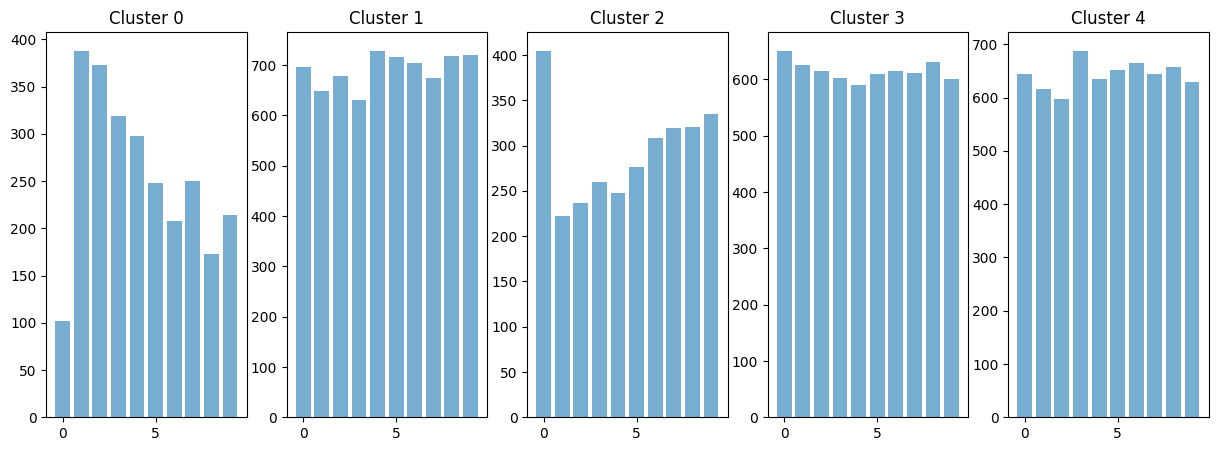

In [48]:
# Plot distribution of labels
# For 26 components
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    ax.bar(np.arange(10), cluster_dist_26[i], alpha=0.6)
    ax.set_title(f'Cluster {i}')

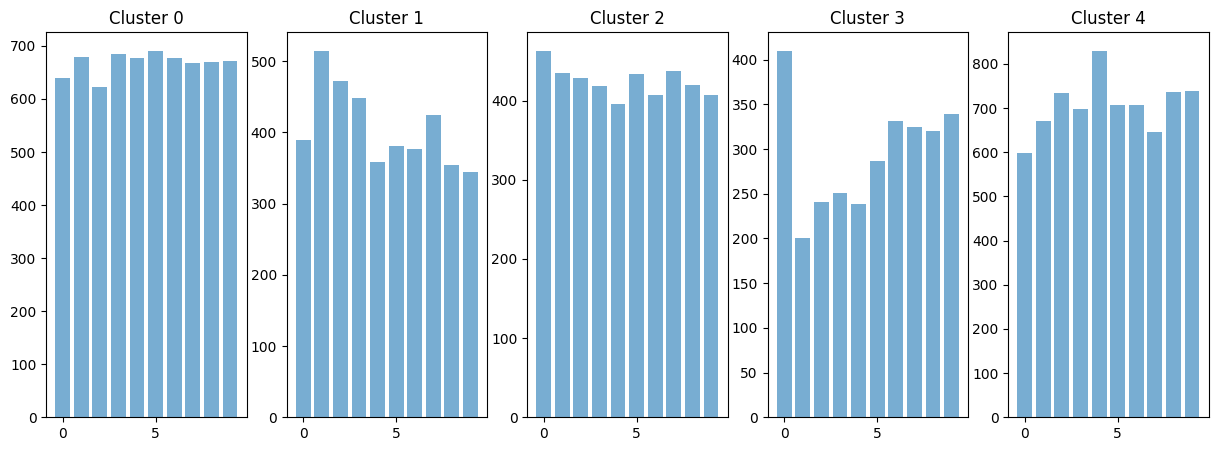

In [49]:
# For 10 components
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    ax.bar(np.arange(10), cluster_dist_10[i], alpha=0.6)
    ax.set_title(f'Cluster {i}')

Some regularities can be observed in the clustering. For example, $1$ and $2$ occur together in clusters formed with $26$ components, while $0, 6$ and $9$ occur together in clusters formed with $10$ components. However, the clustering is not very meaningful, for a few reasons:
- The images are blurry and not very clear
- Several digits occur together in the images
- The images could be clustered together because of other features, like color. 

**Disclaimer**: There might be some randomness in the results due to the random initialization of the centroids.